# Predict 'Converted' Column Using Gradient Descent and Neural Network

## Import

In [10]:
# essentials
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, plot_importance
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
import tensorflow as tf


## Functions

In [14]:
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

def create_model():
    model = Sequential()
    model.add(Dense(24, activation='relu', input_shape=(inputs,)))
    model.add(Dense(16, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc])
    return model

## Wrangle - Version 2

In [12]:
df = pd.read_csv('leads-and-customers.csv')

def mrCleaner(X):
    X = X.copy()
    X['zip'] = X['address'].str.rsplit(
        ' ', 1).str[-1].str.rsplit('-', 1).str[0]
    X['birthdate'] = pd.to_datetime(
        X['birthdate'], infer_datetime_format=True)
    X['birthdate_day'] = X['birthdate'].dt.day
    X['birthdate_month'] = X['birthdate'].dt.month
    X['birthdate_year'] = X['birthdate'].dt.year
    X = X.drop(columns=['birthdate', 'address'])
    X = X.drop(X[X.score < 0].index) # Eliminate negative outlier
    return X

# Split wrangled df into train and test
############################### 
df = mrCleaner(df)

train, test, Y_train, Y_test = train_test_split(df, df.loc[:, ['score']].values, test_size=.25)
train.to_csv("wrangle2_train.csv", index=False)
test.to_csv("wrangle2_test.csv", index=False)

df.shape
print(df.dtypes)
df.head()

mail                                   object
name                                   object
sex                                    object
username                               object
days_since_signup                       int64
acquisition_channel                    object
job_title                              object
company_size                           object
completed_form                          int64
visited_pricing                         int64
registered_for_webinar                  int64
attended_webinar                        int64
industry                               object
converted                               int64
is_manager                               bool
acquisition_channel_Cold Call           int64
acquisition_channel_Cold Email          int64
acquisition_channel_Organic Search      int64
acquisition_channel_Paid Leads          int64
acquisition_channel_Paid Search         int64
company_size_1-10                       int64
company_size_1000-10000           

,mail,name,sex,username,days_since_signup,acquisition_channel,job_title,company_size,completed_form,visited_pricing,...,industry_Furniture,industry_Heavy Manufacturing,Scandanavion Design,Transportation,Internet,score,zip,birthdate_day,birthdate_month,birthdate_year
0,qturner@hotmail.com,Samuel Simpson,M,debrapeterson,18,Organic Search,Marketing Director,11/01/50,1,1,...,0,0,0,0,1,151.000000,91949,8,8,2010
1,carramy@yahoo.com,Angelica Sanchez,F,mbrooks,3,Organic Search,Promotion Manager,251-1000,1,0,...,0,0,0,0,1,141.358438,61475,4,12,1981
2,sbrown@yahoo.com,Connie Taylor,F,aarongriffin,26,Organic Search,Information Systems Manager,1000-10000,0,1,...,0,0,0,0,1,120.448748,56410,25,4,1979
3,bdixon@gmail.com,Alexis Jones,F,jeffreymorales,19,Cold Email,Territory Sales Manager,10-Jan,1,1,...,0,0,0,0,1,250.335264,08748,13,7,2005
4,harrisandrea@gmail.com,Lisa Wright,F,hamiltoncameron,7,Organic Search,Data Processing Manager,10001,1,1,...,0,0,0,0,1,0.000000,36499,19,6,1973


## Gradient Descent Model With Score Feature

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ...................................... , score=1.0, total=   8.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s remaining:    0.0s


[CV] ...................................... , score=1.0, total=   8.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.7s remaining:    0.0s


[CV] ...................................... , score=1.0, total=   8.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.5s remaining:    0.0s


[CV] ...................................... , score=1.0, total=   9.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   35.2s remaining:    0.0s


[CV] ...................................... , score=1.0, total=   8.8s
Mean Estimate Predict Score 1.0


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   44.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   44.0s finished


Actual Predict Score 1.0
----------------------------------------------------------------------------------------------------
score                                 1.0
birthdate_year                        0.0
completed_form                        0.0
acquisition_channel_Cold Email        0.0
acquisition_channel_Cold Call         0.0
is_manager                            0.0
industry                              0.0
attended_webinar                      0.0
registered_for_webinar                0.0
visited_pricing                       0.0
company_size                          0.0
acquisition_channel_Paid Leads        0.0
job_title                             0.0
acquisition_channel                   0.0
days_since_signup                     0.0
username                              0.0
sex                                   0.0
name                                  0.0
acquisition_channel_Organic Search    0.0
acquisition_channel_Paid Search       0.0
birthdate_month                   

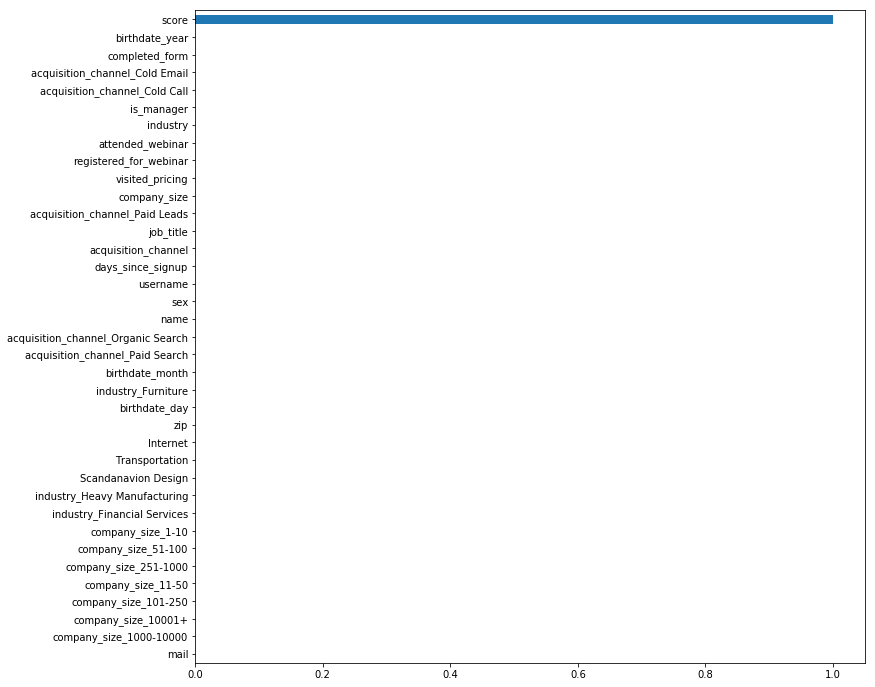

In [16]:
train = pd.read_csv("wrangle2_train.csv")
test  = pd.read_csv("wrangle2_test.csv")
X_train = train.drop(
    columns=['converted'], axis=1)
X_test = test.drop(
    columns=['converted'], axis=1)

y_train = train['converted']
y_test = test['converted']

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)
X_test = encoder.fit_transform(X_test)

clf = XGBClassifier()

# Cross Validation with Kfold=5
print("Mean Estimate Predict Score", cross_val_score(clf, X_train, y_train,
                                                     cv=5, scoring='roc_auc', verbose=10).mean())

clf.fit(X_train, y_train)
print("Actual Predict Score", roc_auc_score(
    y_test, clf.predict_proba(X_test)[:, 1]))

print("-"*100)
fig,ax = plt.subplots(figsize=(12,12))
pd.Series(clf.feature_importances_, X_train.columns).sort_values(
    ascending=True).plot.barh()
plt.show()

## Gradient Descent Model Without Score Feature

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ....................... , score=0.8047851909352421, total=  11.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.2s remaining:    0.0s


[CV] ....................... , score=0.8026573871256935, total=  11.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.4s remaining:    0.0s


[CV] ....................... , score=0.8063466234551566, total=  11.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   33.5s remaining:    0.0s


[CV] ....................... , score=0.8059321475228014, total=  11.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   44.7s remaining:    0.0s


[CV] ....................... , score=0.7918155160254537, total=  11.1s
Mean Estimate Predict Score 0.8023073730128696


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   55.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   55.7s finished


Actual Predict Score 0.8096487955575498
----------------------------------------------------------------------------------------------------


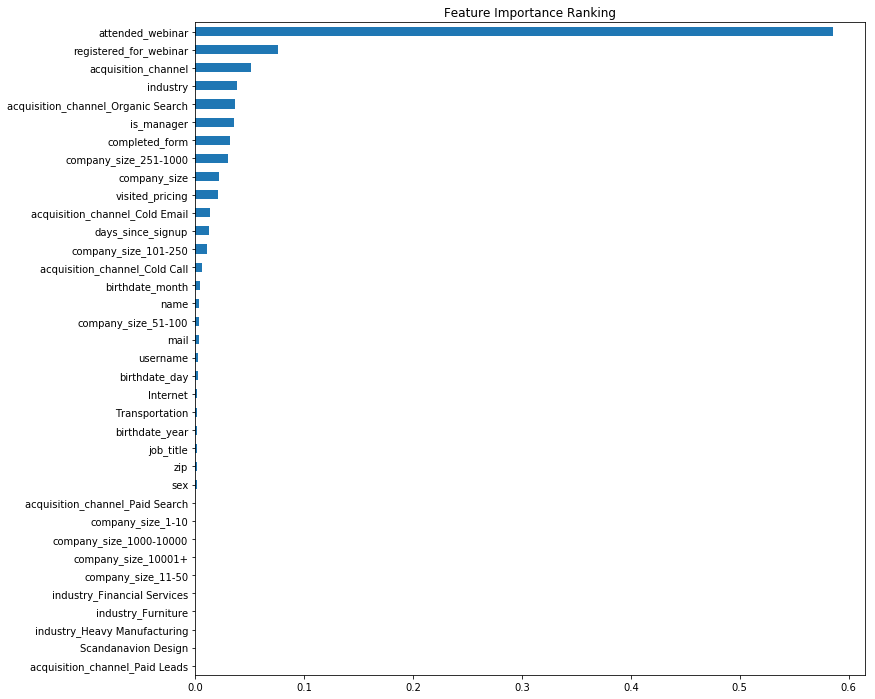

In [17]:
train = pd.read_csv("wrangle2_train.csv")
test  = pd.read_csv("wrangle2_test.csv")
X_train = train.drop(
    columns=['converted','score'], axis=1)
X_test = test.drop(
    columns=['converted','score'], axis=1)

y_train = train['converted']
y_test = test['converted']

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)
X_test = encoder.fit_transform(X_test)

clf = XGBClassifier()

# Cross Validation with Kfold=5
print("Mean Estimate Predict Score", cross_val_score(clf, X_train, y_train,
                                                     cv=5, scoring='roc_auc', verbose=10).mean())

clf.fit(X_train, y_train)
print("Actual Predict Score", roc_auc_score(
    y_test, clf.predict_proba(X_test)[:, 1]))

print("-"*100)
fig,ax = plt.subplots(figsize=(12,12))
plt.title('Feature Importance Ranking')
pd.Series(clf.feature_importances_, X_train.columns).sort_values(
    ascending=True).plot.barh()
plt.show()

## Neural Network Without Score Feature

In [21]:
X = df.drop(columns=['converted','score'], axis=1)
y = df['converted']

encoder = ce.OrdinalEncoder()
X = encoder.fit_transform(X)

scaler = StandardScaler()
X = scaler.fit_transform(X)

inputs = 36
epochs = 20
batch_size = 20

model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=1)

#k-fold cross validation
cross_val_score(model, X, y, cv=5, scoring='roc_auc')


/home/superio/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/superio/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Epoch 1/20
79992/79992 [==============================] - 32s 404us/step - loss: 0.3722 - auc: 0.7746
Epoch 2/20
79992/79992 [==============================] - 24s 300us/step - loss: 0.3408 - auc: 0.8028
Epoch 3/20
79992/79992 [==============================] - 22s 279us/step - loss: 0.3355 - auc: 0.8063
Epoch 4/20
79992/79992 [==============================] - 25s 312us/step - loss: 0.3333 - auc: 0.8082
Epoch 5/20
79992/79992 [==============================] - 33s 418us/step - loss: 0.3320 - auc: 0.8100
Epoch 6/20
79992/79992 [==============================] - 31s 385us/step - loss: 0.3309 - auc: 0.8113
Epoch 7/20
79992/79992 [==============================] - 30s 373us/step - loss: 0.3304 - auc: 0.8125
Epoch 8/20
79992/79992 [==============================] - 33s 414us/step - loss: 0.3295 - auc: 0.8134
Epoch 9/20
79992/79992 [==============================] - 35s 434us/step - loss: 0.3288 - auc: 0.8144
Epoch 10/20
79992/79992 [==============================] - 33s 413us/step - loss: 

79992/79992 [==============================] - 21s 262us/step - loss: 0.3234 - auc: 0.8199
Epoch 20/20
19998/19998 [==============================] - 2s 105us/step
Epoch 1/20
79992/79992 [==============================] - 25s 314us/step - loss: 0.3637 - auc: 0.7912
Epoch 2/20
79992/79992 [==============================] - 22s 275us/step - loss: 0.3379 - auc: 0.8067
Epoch 3/20
79992/79992 [==============================] - 24s 298us/step - loss: 0.3343 - auc: 0.8095
Epoch 4/20
79992/79992 [==============================] - 22s 274us/step - loss: 0.3320 - auc: 0.8106
Epoch 5/20
79992/79992 [==============================] - 22s 276us/step - loss: 0.3302 - auc: 0.8120
Epoch 6/20
79992/79992 [==============================] - 22s 281us/step - loss: 0.3298 - auc: 0.8126
Epoch 7/20
79992/79992 [==============================] - 22s 274us/step - loss: 0.3287 - auc: 0.8134
Epoch 8/20
79992/79992 [==============================] - 25s 314us/step - loss: 0.3281 - auc: 0.8142
Epoch 9/20
79992/799

array([0.81409106, 0.80535419, 0.80348536, 0.80550424, 0.80951661])